In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sqlite3
print(os.getcwd())

/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/brfss_eda


Defines `all_vars`: the set of BRFSS variables to keep when reading yearly XPT files (smoking, demographics, weights, tobacco use, etc.).

In [3]:
all_vars = [
    "SMOKDAY2", "INCOME2", "INCOME3", "_AGEG5YR",
    "PRIMINS1", "YEAR", "_STATE", "SEXVAR", "POORHLTH", "STOPSMK2", "_LLCPWT", "_FINALWT", 
    "USENOW3", "ECIGNOW", "ECIGNOW1", "ECIGNOW2", "CIGARUSE"
]


Opens a sqlite3 connection and iterates over `data_config` mapping years → XPT file paths; reads each SAS/XPT file, keeps only `all_vars` columns, tags rows with `YEAR`, and appends to a `brfss` SQL table. Creates indexes on YEAR and _STATE and closes the DB.

In [ ]:
conn = sqlite3.connect('brfss_data.db')

data_config = {
    2009: "/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/CDBRFS09XPT/CDBRFS09.XPT",
    2010: "/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/CDBRFS10XPT/CDBRFS10.XPT",
    2011: "/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/LLCP2011XPT/LLCP2011.XPT",
    2012: "/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/LLCP2012XPT/LLCP2012.XPT",
    2013: "/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/LLCP2013XPT/LLCP2013.XPT",
    2014: "/home/parkermorrow/Downloads/LLCP2014XPT(2)/LLCP2014.XPT ",
    2015: "/home/parkermorrow/Downloads/LLCP2015XPT(1)/LLCP2015.XPT ",
    2016: "/home/parkermorrow/Downloads/LLCP2016XPT(1)/LLCP2016.XPT ",
    2017: "/home/parkermorrow/Downloads/LLCP2017XPT(1)/LLCP2017.XPT ",
    2018: "/home/parkermorrow/Downloads/LLCP2018XPT(1)/LLCP2018.XPT ",
    2019: "/home/parkermorrow/Downloads/LLCP2019XPT(1)/LLCP2019.XPT ",
    2020: "/home/parkermorrow/Downloads/LLCP2020XPT(1)/LLCP2020.XPT ",
    2021: "/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/LLCP2021XPT/LLCP2021.XPT ",
    2022: "/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/LLCP2022XPT/LLCP2022.XPT ",
    2023: "/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/LLCP2023XPT/LLCP2023.XPT ",
}

for year, filepath in data_config.items():
    df = pd.read_sas(filepath)
    df = df[[col for col in all_vars if col in df.columns]]
    df["YEAR"] = year
    df.to_sql('brfss', conn, if_exists='append', index=False)

conn.execute("CREATE INDEX IF NOT EXISTS idx_year ON brfss(YEAR)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_state ON brfss(_STATE)")
conn.commit()
conn.close()

In [8]:
cols = ["ECIGNOW", "ECIGNOW1", "ECIGNOW2"]
for c in cols:
    if c in df.columns:
        print(f"{c} non-missing by year:")
        out = df.groupby("YEAR")[c].agg(lambda s: s.notna().mean()).round(3)
        print(out.tail(15), "\n")



ECIGNOW non-missing by year:
YEAR
2009    0.000
2010    0.000
2011    0.000
2012    0.000
2013    0.000
2014    0.000
2015    0.000
2016    0.153
2017    0.148
2018    0.111
2019    0.000
2020    0.126
2021    0.000
2022    0.000
2023    0.000
Name: ECIGNOW, dtype: float64 

ECIGNOW1 non-missing by year:
YEAR
2009    0.000
2010    0.000
2011    0.000
2012    0.000
2013    0.000
2014    0.000
2015    0.000
2016    0.000
2017    0.000
2018    0.000
2019    0.000
2020    0.000
2021    0.948
2022    0.000
2023    0.000
Name: ECIGNOW1, dtype: float64 

ECIGNOW2 non-missing by year:
YEAR
2009    0.000
2010    0.000
2011    0.000
2012    0.000
2013    0.000
2014    0.000
2015    0.000
2016    0.000
2017    0.000
2018    0.000
2019    0.000
2020    0.000
2021    0.000
2022    0.925
2023    0.950
Name: ECIGNOW2, dtype: float64 



Creates `ECIG_NOW_ANY` by taking the first non-missing among available ECIG columns. Constructs binary indicators: `cig_smoker`, `ecig_user`, `other_tobacco`, `is_any_smoker`, and `is_non_ecig_smoker`.

In [ ]:
ecig_cols = [c for c in ["ECIGNOW2","ECIGNOW1","ECIGNOW"] if c in df.columns]
df["ECIG_NOW_ANY"] = (pd.concat([df[c] for c in ecig_cols], axis=1)
                        .bfill(axis=1)  # first non-missing across candidates
                        .iloc[:,0])

df["cig_smoker"] = df["SMOKDAY2"].isin([1,2]).astype("float64")
df["ecig_user"] = df["ECIG_NOW_ANY"].isin([1,2]).astype("float64")
df["other_tobacco"] = df["USENOW3"].isin([1,2]).astype("float64")

df["is_any_smoker"] = ((df["cig_smoker"]==1) | (df["ecig_user"]==1) | (df["other_tobacco"]==1)).astype("float64")
df["is_non_ecig_smoker"]= ((df["cig_smoker"]==1) | (df["other_tobacco"]==1)).astype("float64")


In [11]:
for y in [2016, 2017, 2018, 2020, 2021, 2022, 2023]:
    sub = df[df["YEAR"] == y]
    print(f"\nYEAR {y}")
    for raw in ["ECIGNOW","ECIGNOW1","ECIGNOW2"]:
        if raw in df.columns:
            share = (sub["ECIG_NOW_ANY"] == sub[raw]).mean()
            print(f"share ECIG_NOW_ANY == {raw}: {share:.3f}")



YEAR 2016
share ECIG_NOW_ANY == ECIGNOW: 0.153
share ECIG_NOW_ANY == ECIGNOW1: 0.000
share ECIG_NOW_ANY == ECIGNOW2: 0.000

YEAR 2017
share ECIG_NOW_ANY == ECIGNOW: 0.148
share ECIG_NOW_ANY == ECIGNOW1: 0.000
share ECIG_NOW_ANY == ECIGNOW2: 0.000

YEAR 2018
share ECIG_NOW_ANY == ECIGNOW: 0.111
share ECIG_NOW_ANY == ECIGNOW1: 0.000
share ECIG_NOW_ANY == ECIGNOW2: 0.000

YEAR 2020
share ECIG_NOW_ANY == ECIGNOW: 0.126
share ECIG_NOW_ANY == ECIGNOW1: 0.000
share ECIG_NOW_ANY == ECIGNOW2: 0.000

YEAR 2021
share ECIG_NOW_ANY == ECIGNOW: 0.000
share ECIG_NOW_ANY == ECIGNOW1: 0.948
share ECIG_NOW_ANY == ECIGNOW2: 0.000

YEAR 2022
share ECIG_NOW_ANY == ECIGNOW: 0.000
share ECIG_NOW_ANY == ECIGNOW1: 0.000
share ECIG_NOW_ANY == ECIGNOW2: 0.925

YEAR 2023
share ECIG_NOW_ANY == ECIGNOW: 0.000
share ECIG_NOW_ANY == ECIGNOW1: 0.000
share ECIG_NOW_ANY == ECIGNOW2: 0.950


In [7]:
df.head()

,SMOKDAY2,INCOME2,_AGEG5YR,_STATE,POORHLTH,STOPSMK2,_FINALWT,USENOW3,YEAR,_LLCPWT,ECIGNOW,SEXVAR,INCOME3,ECIGNOW2,PRIMINS1
0,3.0,6.0,8.0,1.0,NaN,NaN,758.095207,3.0,2009,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,8.0,11.0,1.0,88.0,2.0,306.537464,3.0,2009,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,4.0,10.0,1.0,77.0,1.0,188.928468,3.0,2009,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,5.0,7.0,1.0,30.0,NaN,552.713855,3.0,2009,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,8.0,5.0,1.0,88.0,NaN,55.189540,3.0,2009,NaN,NaN,NaN,NaN,NaN,NaN


Plots a large heatmap showing missingness across variables and rows to visually inspect gaps in the dataset.

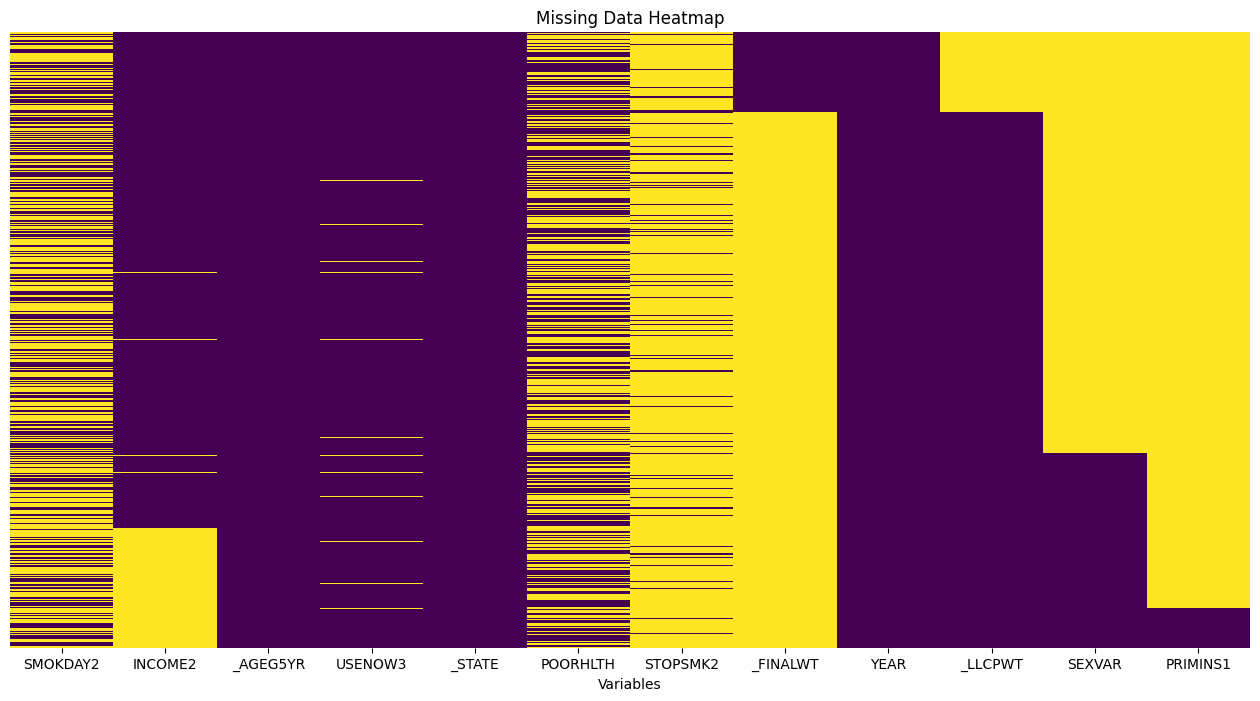

In [118]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.xlabel("Variables")
plt.show()

Plots the fraction missing per column (bar chart) to prioritise cleaning and identify problematic variables.

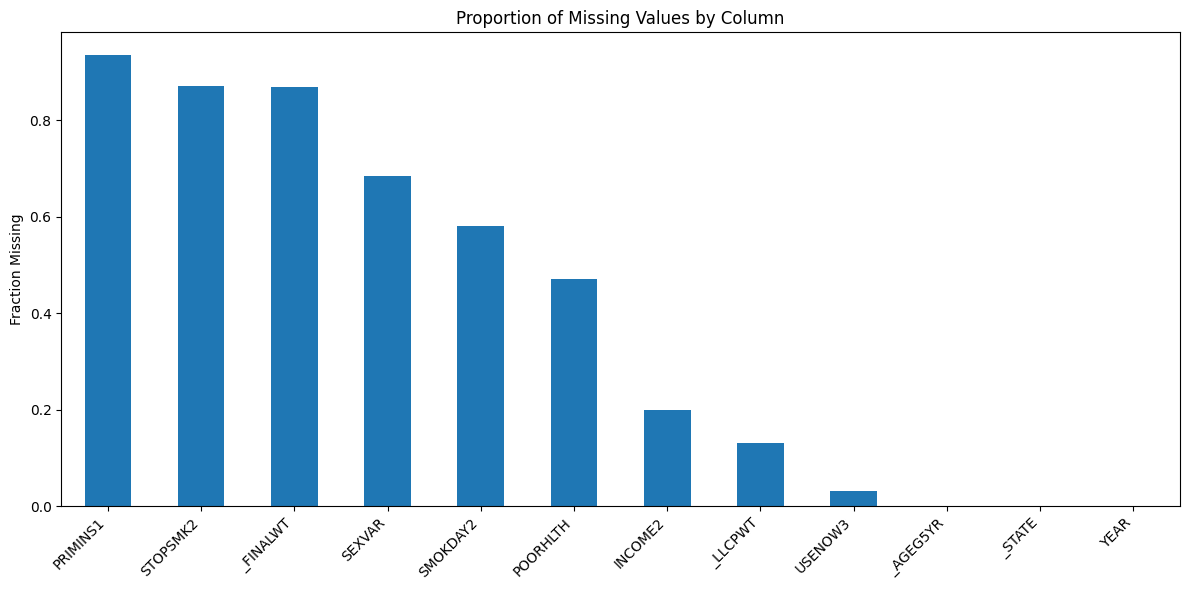

In [119]:
df.isnull().mean().sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("Proportion of Missing Values by Column")
plt.ylabel("Fraction Missing")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [120]:
df.shape

(6774858, 12)

In [121]:
df.dtypes

SMOKDAY2    float64
INCOME2     float64
_AGEG5YR    float64
USENOW3     float64
_STATE      float64
POORHLTH    float64
STOPSMK2    float64
_FINALWT    float64
YEAR          int64
_LLCPWT     float64
SEXVAR      float64
PRIMINS1    float64
dtype: object

In [122]:
df.describe()

,SMOKDAY2,INCOME2,_AGEG5YR,USENOW3,_STATE,POORHLTH,STOPSMK2,_FINALWT,YEAR,_LLCPWT,SEXVAR,PRIMINS1
count,2.831636e+06,5.420934e+06,6.774858e+06,6.558394e+06,6.774858e+06,3.582882e+06,871652.000000,883682.000000,6.774858e+06,5.891176e+06,2.137374e+06,433318.000000
mean,2.427318e+00,1.861297e+01,7.768547e+00,2.965230e+00,2.985042e+01,5.509798e+01,1.463267,534.233009,2.015863e+03,5.555106e+02,1.536524e+00,10.865293
std,8.870059e-01,3.041238e+01,3.521734e+00,4.103976e-01,1.592197e+01,3.822400e+01,0.610312,1000.668888,4.294171e+00,1.070911e+03,4.986643e-01,24.899418
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.448975,2.009000e+03,2.046386e-02,1.000000e+00,1.000000
25%,2.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,1.800000e+01,1.000000e+01,1.000000,89.220530,2.012000e+03,9.248435e+01,1.000000e+00,1.000000
50%,3.000000e+00,7.000000e+00,8.000000e+00,3.000000e+00,2.900000e+01,8.800000e+01,1.000000,225.907920,2.016000e+03,2.374095e+02,2.000000e+00,3.000000
75%,3.000000e+00,8.000000e+00,1.100000e+01,3.000000e+00,4.200000e+01,8.800000e+01,2.000000,569.740498,2.020000e+03,5.872492e+02,2.000000e+00,5.000000
max,9.000000e+00,9.900000e+01,1.400000e+01,9.000000e+00,7.800000e+01,9.900000e+01,9.000000,67732.119433,2.023000e+03,8.319332e+04,2.000000e+00,99.000000


In [123]:
df.isna().mean()


SMOKDAY2    0.582038
INCOME2     0.199845
_AGEG5YR    0.000000
USENOW3     0.031951
_STATE      0.000000
POORHLTH    0.471150
STOPSMK2    0.871340
_FINALWT    0.869564
YEAR        0.000000
_LLCPWT     0.130436
SEXVAR      0.684514
PRIMINS1    0.936040
dtype: float64

In [124]:
df["SMOKDAY2"].value_counts(dropna=False)

SMOKDAY2
NaN    3943222
3.0    1869659
1.0     688524
2.0     268889
9.0       3027
7.0       1537
Name: count, dtype: int64

Creates `weight` column by using `_LLCPWT` for 2011+ and `_FINALWT` for earlier years; defines `is_smoker` and computes weighted average smoking rate by age group.

In [125]:
df["weight"] = df.apply(lambda row: row["_LLCPWT"] if row["YEAR"] >= 2011 else row["_FINALWT"], axis=1)

df["is_smoker"] = df["SMOKDAY2"].isin([1, 2]).astype(int)

def weighted_rate(group):
    return np.average(group["is_smoker"], weights=group["weight"])

age_smok_rate_wt = df.groupby("_AGEG5YR").apply(weighted_rate)


/tmp/ipykernel_5489/3526427346.py:8: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [126]:
df.head()

,SMOKDAY2,INCOME2,_AGEG5YR,USENOW3,_STATE,POORHLTH,STOPSMK2,_FINALWT,YEAR,_LLCPWT,SEXVAR,PRIMINS1,weight,is_smoker
0,3.0,6.0,8.0,3.0,1.0,NaN,NaN,758.095207,2009,NaN,NaN,NaN,758.095207,0
1,1.0,8.0,11.0,3.0,1.0,88.0,2.0,306.537464,2009,NaN,NaN,NaN,306.537464,1
2,1.0,4.0,10.0,3.0,1.0,77.0,1.0,188.928468,2009,NaN,NaN,NaN,188.928468,1
3,3.0,5.0,7.0,3.0,1.0,30.0,NaN,552.713855,2009,NaN,NaN,NaN,552.713855,0
4,NaN,8.0,5.0,3.0,1.0,88.0,NaN,55.189540,2009,NaN,NaN,NaN,55.189540,0


Defines readable age labels, counts respondents by `_AGEG5YR`, maps labels, and plots respondent counts by age group.

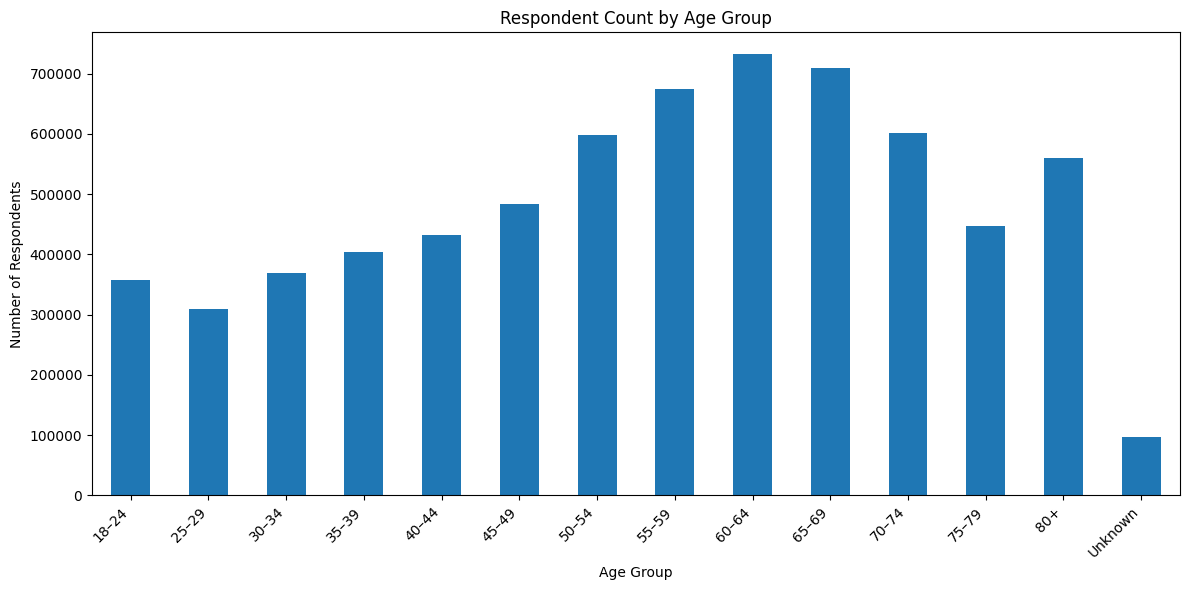

In [127]:
age_labels = {
    1: "18–24", 2: "25–29", 3: "30–34", 4: "35–39", 5: "40–44",
    6: "45–49", 7: "50–54", 8: "55–59", 9: "60–64", 10: "65–69",
    11: "70–74", 12: "75–79", 13: "80+", 14: "Unknown"
}

age_counts = df["_AGEG5YR"].value_counts().sort_index()
age_counts.index = age_counts.index.map(age_labels)

age_counts.plot(kind='bar', figsize=(12, 6))
plt.title("Respondent Count by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Respondents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Computes and plots weighted respondent representation by age group (sum of weights per age bin).

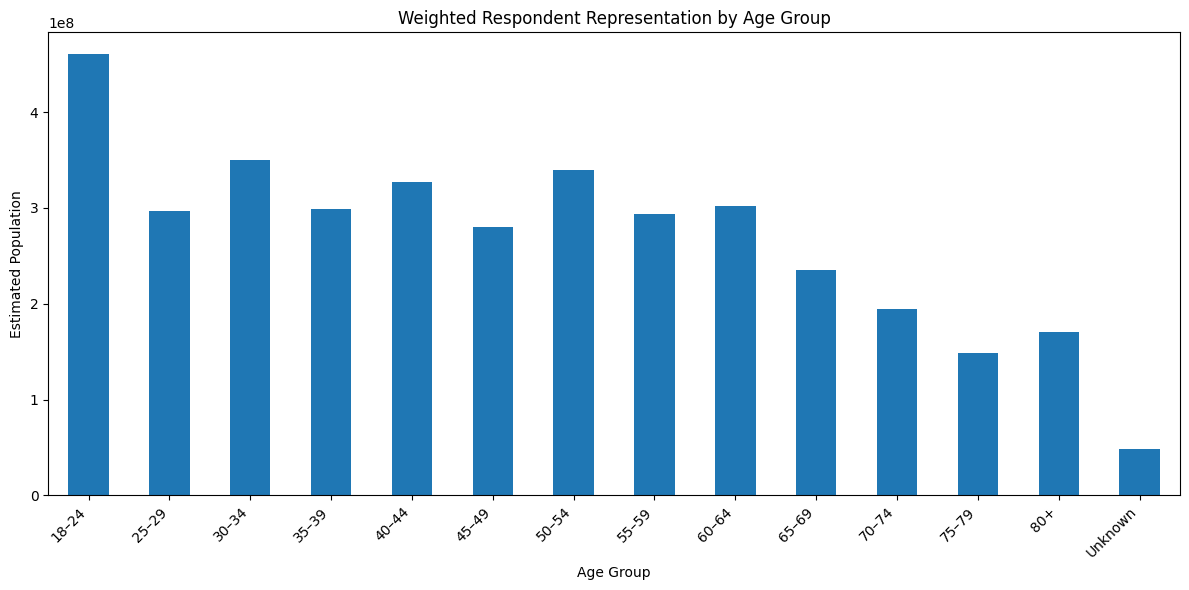

In [128]:
age_weighted_counts = df.groupby("_AGEG5YR")["weight"].sum().sort_index()
age_weighted_counts.index = age_weighted_counts.index.map(age_labels)

age_weighted_counts.plot(kind='bar', figsize=(12, 6))
plt.title("Weighted Respondent Representation by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Estimated Population")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [129]:
df_post2014 = df[df["YEAR"] >= 2014].copy()


In [130]:
df_post2014

,SMOKDAY2,INCOME2,_AGEG5YR,USENOW3,_STATE,POORHLTH,STOPSMK2,_FINALWT,YEAR,_LLCPWT,SEXVAR,PRIMINS1,weight,is_smoker
2357609,3.0,7.0,9.0,3.0,1.0,88.0,NaN,NaN,2014,98.076831,NaN,NaN,98.076831,0
2357610,NaN,4.0,11.0,3.0,1.0,7.0,NaN,NaN,2014,137.527171,NaN,NaN,137.527171,0
2357611,3.0,7.0,7.0,3.0,1.0,NaN,NaN,NaN,2014,284.683886,NaN,NaN,284.683886,0
2357612,NaN,5.0,10.0,3.0,1.0,88.0,NaN,NaN,2014,62.680861,NaN,NaN,62.680861,0
2357613,NaN,4.0,10.0,3.0,1.0,88.0,NaN,NaN,2014,186.182279,NaN,NaN,186.182279,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6774853,NaN,NaN,10.0,3.0,78.0,11.0,NaN,NaN,2023,39.700749,1.0,77.0,39.700749,0
6774854,NaN,NaN,3.0,3.0,78.0,NaN,NaN,NaN,2023,39.132414,2.0,1.0,39.132414,0
6774855,NaN,NaN,7.0,3.0,78.0,88.0,NaN,NaN,2023,40.185536,2.0,1.0,40.185536,0
6774856,NaN,NaN,10.0,3.0,78.0,NaN,NaN,NaN,2023,1.737941,2.0,3.0,1.737941,0


In [131]:
df.isna().mean().round(3)

SMOKDAY2     0.582
INCOME2      0.200
_AGEG5YR     0.000
USENOW3      0.032
_STATE       0.000
POORHLTH     0.471
STOPSMK2     0.871
_FINALWT     0.870
YEAR         0.000
_LLCPWT      0.130
SEXVAR       0.685
PRIMINS1     0.936
weight       0.000
is_smoker    0.000
dtype: float64

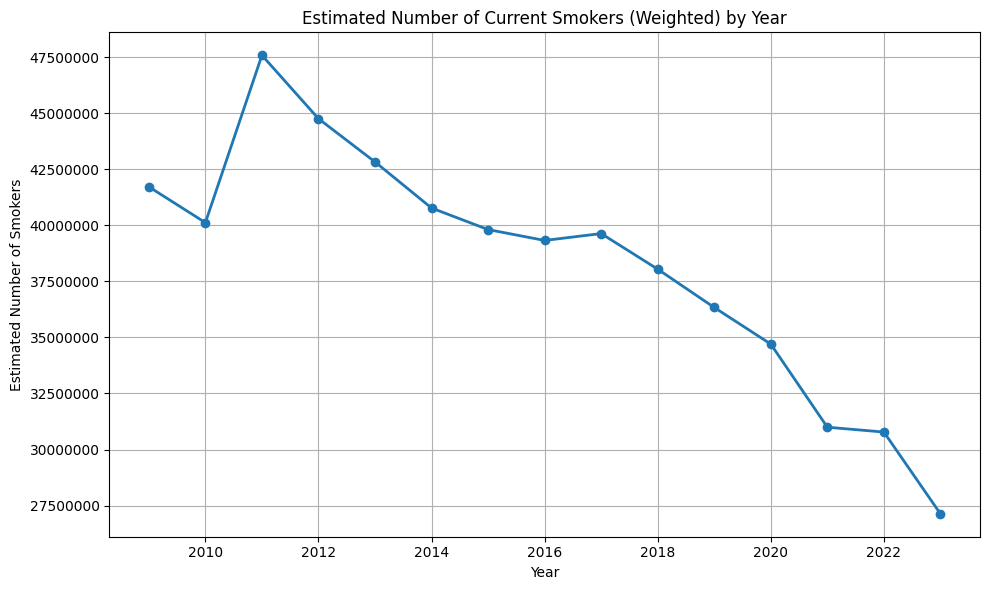

In [132]:
df['WEIGHT'] = df['_LLCPWT']
df.loc[df['YEAR'] < 2011, 'WEIGHT'] = df.loc[df['YEAR'] < 2011, '_FINALWT']

df_smokers = df[df["SMOKDAY2"].isin([1.0, 2.0])]

smoker_counts = df_smokers.groupby("YEAR")["WEIGHT"].sum()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(smoker_counts.index, smoker_counts.values, marker="o", linewidth=2)
plt.title("Estimated Number of Current Smokers (Weighted) by Year")
plt.xlabel("Year")
plt.ylabel("Estimated Number of Smokers")
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.tight_layout()
plt.show()


In [133]:
smoker_counts = df_smokers.groupby(["YEAR", "_STATE"])["WEIGHT"].sum().unstack(fill_value=0)


In [135]:
fips_to_state = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California", 8: "Colorado",
    9: "Connecticut", 10: "Delaware", 11: "DC", 12: "Florida", 13: "Georgia", 15: "Hawaii",
    16: "Idaho", 17: "Illinois", 18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky",
    22: "Louisiana", 23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan",
    27: "Minnesota", 28: "Mississippi", 29: "Missouri", 30: "Montana", 31: "Nebraska",
    32: "Nevada", 33: "New Hampshire", 34: "New Jersey", 35: "New Mexico", 36: "New York",
    37: "North Carolina", 38: "North Dakota", 39: "Ohio", 40: "Oklahoma", 41: "Oregon",
    42: "Pennsylvania", 44: "Rhode Island", 45: "South Carolina", 46: "South Dakota",
    47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont", 51: "Virginia", 53: "Washington",
    54: "West Virginia", 55: "Wisconsin", 56: "Wyoming"
}


In [136]:
df["WEIGHT"] = df["_LLCPWT"]
df.loc[df["YEAR"] < 2011, "WEIGHT"] = df.loc[df["YEAR"] < 2011, "_FINALWT"]
df["is_smoker"] = df["SMOKDAY2"].isin([1.0, 2.0]).astype(int)

In [137]:
df_smokers = df[df["is_smoker"] == 1]

smoker_counts = (
    df_smokers
    .groupby(["YEAR", "_STATE"])["WEIGHT"]
    .sum()
    .unstack(fill_value=0)
)


In [138]:
def weighted_smoking_rate(group):
    return np.average(group["is_smoker"], weights=group["WEIGHT"])

smoking_rates = (
    df.groupby(["YEAR", "_STATE"])
    .apply(weighted_smoking_rate)
    .unstack(fill_value=np.nan)
)


/tmp/ipykernel_5489/587084592.py:6: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [139]:
smoking_rates.columns = smoking_rates.columns.map(lambda x: fips_to_state.get(int(x), f"FIPS {x}"))


Computes full dataframe correlation matrix (`df.corr()`) as a quick check.

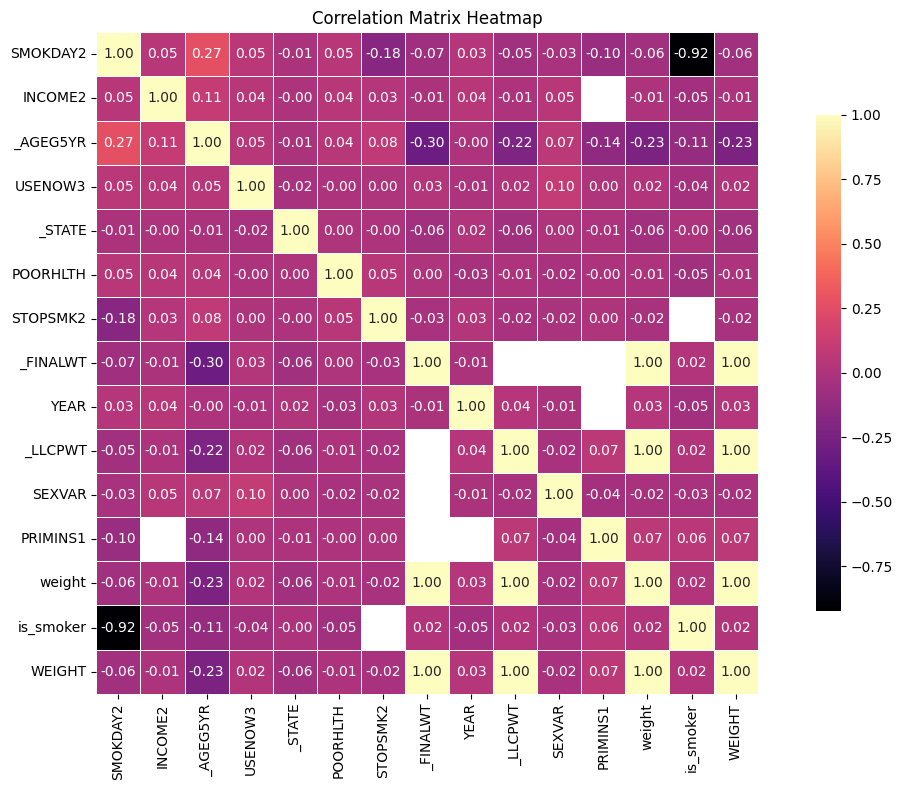

In [142]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="magma",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)

plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()


Constructs `smoke_rates_wt` (weighted proportion of smokers by YEAR×_STATE), plots all state lines in one large figure.

/tmp/ipykernel_5489/3046087988.py:15: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



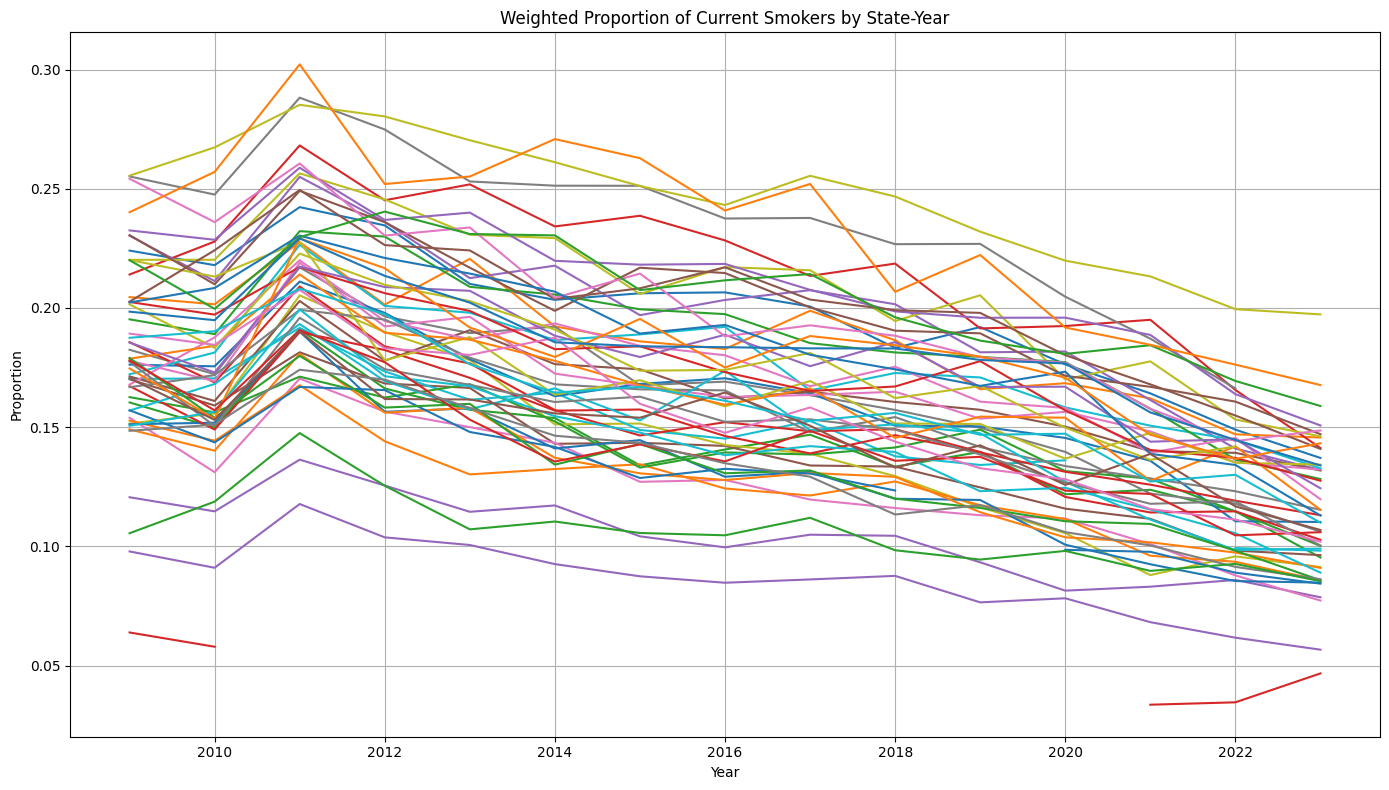

In [143]:
# make sure these columns exist first
df["WEIGHT"] = df["_LLCPWT"]
df.loc[df["YEAR"] < 2011, "WEIGHT"] = df.loc[df["YEAR"] < 2011, "_FINALWT"]

# define smoker as binary
df["is_smoker"] = df["SMOKDAY2"].isin([1.0, 2.0]).astype(int)

# weighted smoking rate by state and year
def weighted_smoke_rate(group):
    return np.average(group["is_smoker"], weights=group["WEIGHT"])

# groupby state and year
smoke_rates_wt = (
    df.groupby(["YEAR", "_STATE"])
    .apply(weighted_smoke_rate)
    .unstack()
)

# plot
smoke_rates_wt.plot(figsize=(14, 8), legend=False)
plt.title("Weighted Proportion of Current Smokers by State-Year")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.grid(True)
plt.tight_layout()
plt.show()


Add weights

In [144]:
income_labels = {
    1: "<$10k", 
    2: "<$15k", 
    3: "<$20k", 
    4: "<$25k", 
    5: "<$35k", 
    6: "<$50k", 
    7: "<$75k", 
    8: "<$100k", 
    9: "<$150k", 
    10: "<$200k", 
    11: ">$200k", 
    77: "Don't know", 
    99: "Refused"
}

In [145]:
smokday2_labels = {
    1: "Every day",
    2: "Some days",
    3: "Not at all",
    7: "Don't know",
    9: "Refused"
}

In [146]:
df["INCOME2"].value_counts()

INCOME2
8.0     1387448
7.0      728028
6.0      663099
5.0      511283
99.0     447268
4.0      433170
77.0     393953
3.0      352360
2.0      260870
1.0      243455
Name: count, dtype: int64

Creates a cross-tab (proportions by income) of smoking frequency, maps readable labels, and plots stacked bar chart.

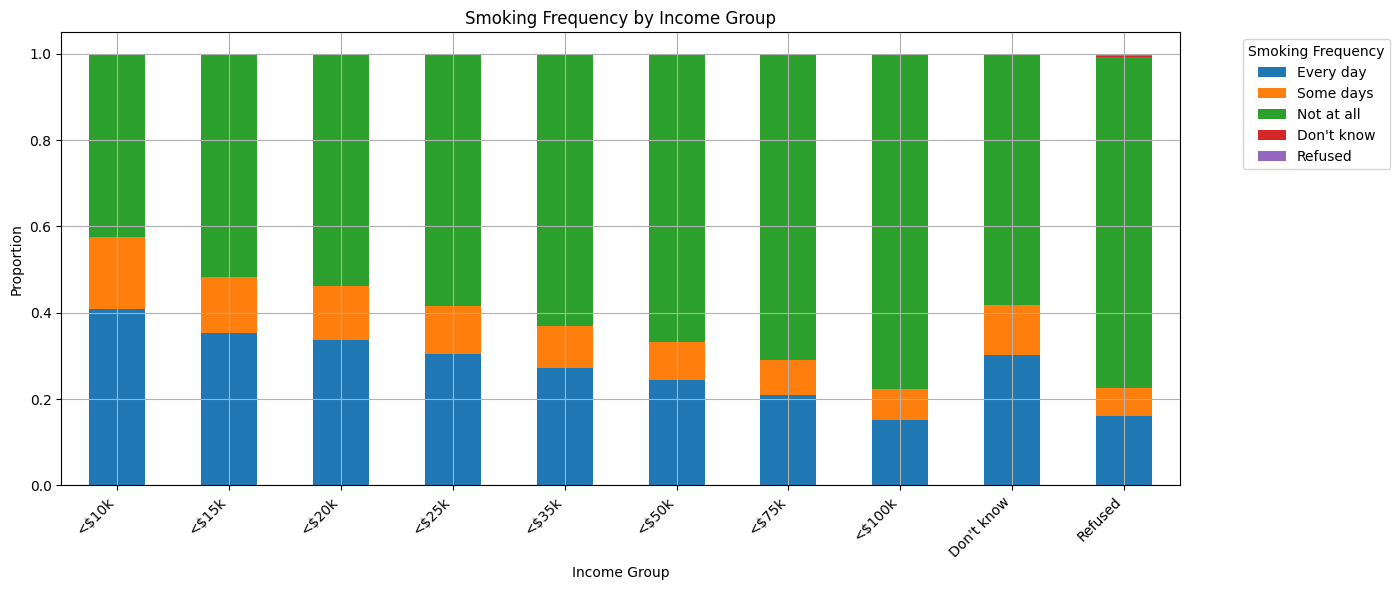

In [147]:
ct = pd.crosstab(df["INCOME2"], df["SMOKDAY2"], normalize='index')

ct.index = ct.index.map(income_labels)
ct.columns = ct.columns.map(smokday2_labels)

ct.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Smoking Frequency by Income Group")
plt.ylabel("Proportion")
plt.xlabel("Income Group")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Smoking Frequency", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Computes weighted proportions of smoking frequency by income group using weights, maps labels, and plots stacked bar chart (weighted).

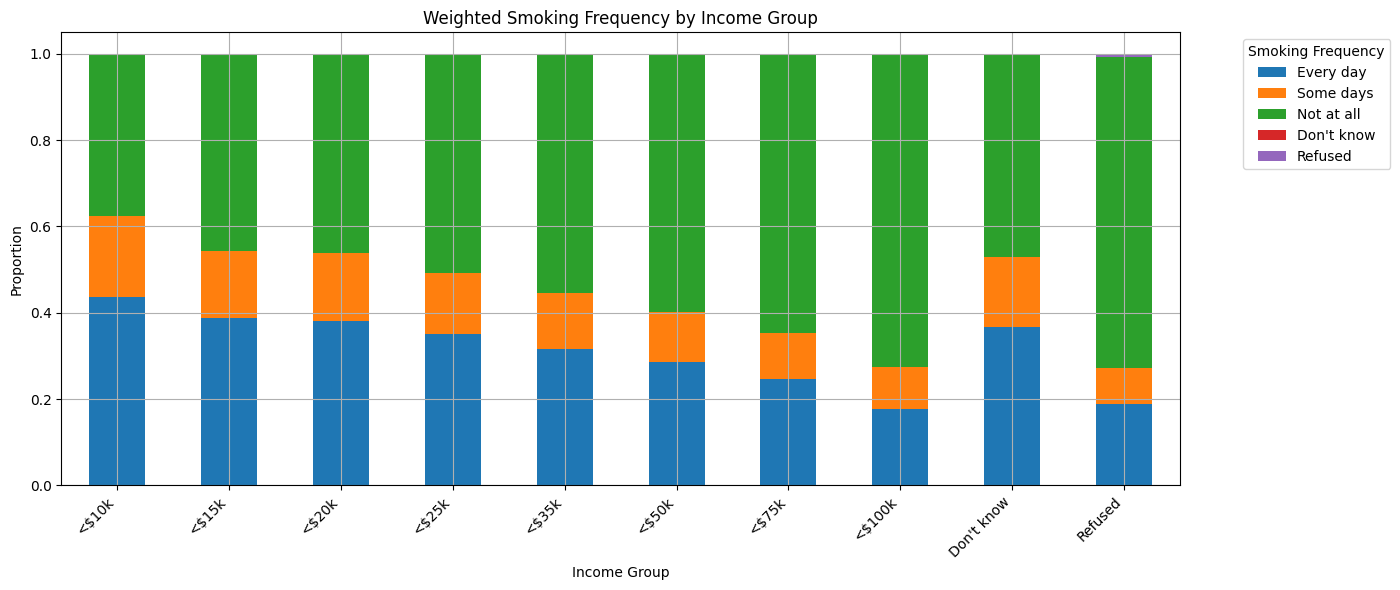

In [148]:

weighted_ct = (
    df
    .groupby(["INCOME2", "SMOKDAY2"])["WEIGHT"]
    .sum()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
)

weighted_ct.index = weighted_ct.index.get_level_values(0).map(income_labels)
weighted_ct.columns = weighted_ct.columns.map(smokday2_labels)


# plot
weighted_ct.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Weighted Smoking Frequency by Income Group")
plt.ylabel("Proportion")
plt.xlabel("Income Group")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Smoking Frequency", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [149]:
df["INCOME2"].value_counts()

INCOME2
8.0     1387448
7.0      728028
6.0      663099
5.0      511283
99.0     447268
4.0      433170
77.0     393953
3.0      352360
2.0      260870
1.0      243455
Name: count, dtype: int64

The Don't Know and Refused are in the legend too, so ignore that for now. 

Defines `insurance_map` mapping PRIMINS1 codes to readable insurance labels and creates `INS_LABEL`.

In [150]:
insurance_map = {
    1: "Employer/Union Plan",
    2: "Private Nongov Plan",
    3: "Medicare",
    4: "Medigap",
    5: "Medicaid",
    6: "CHIP",
    7: "Military/VA/CHAMP",
    8: "Indian Health Service",
    9: "State Sponsored",
    10: "Other Govt Program",
    88: "No Coverage",
    77: "Don't Know",
    99: "Refused"
}

df["INS_LABEL"] = df["PRIMINS1"].map(insurance_map)


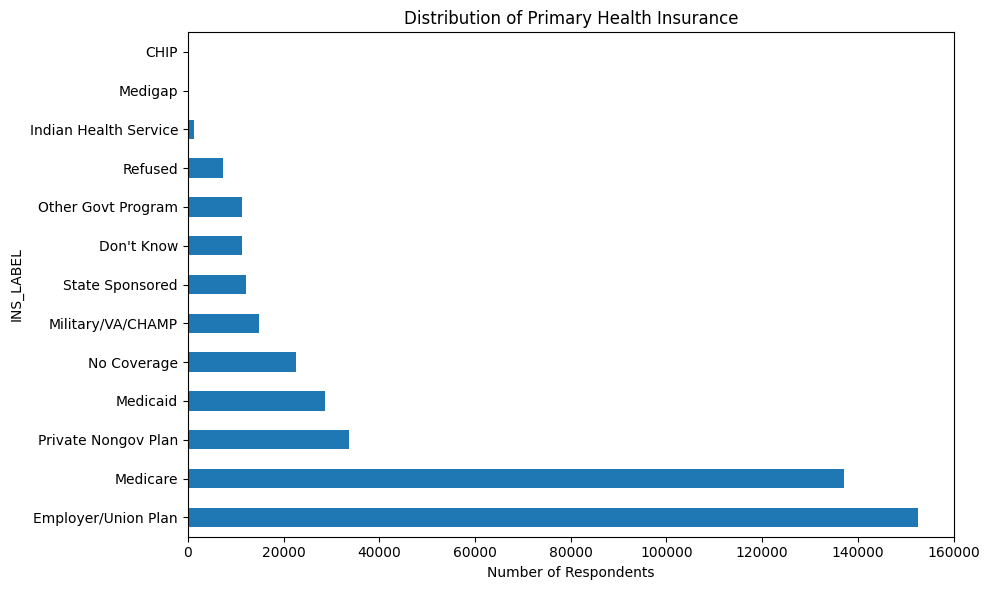

In [151]:
df["INS_LABEL"].value_counts().plot(kind="barh", figsize=(10, 6))
plt.title("Distribution of Primary Health Insurance")
plt.xlabel("Number of Respondents")
plt.tight_layout()
plt.show()


Computes weighted smoking rate by `INS_LABEL` (dropping missing), sorts and plots bar chart of smoking rates across insurance types.

/tmp/ipykernel_5489/3225567648.py:7: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



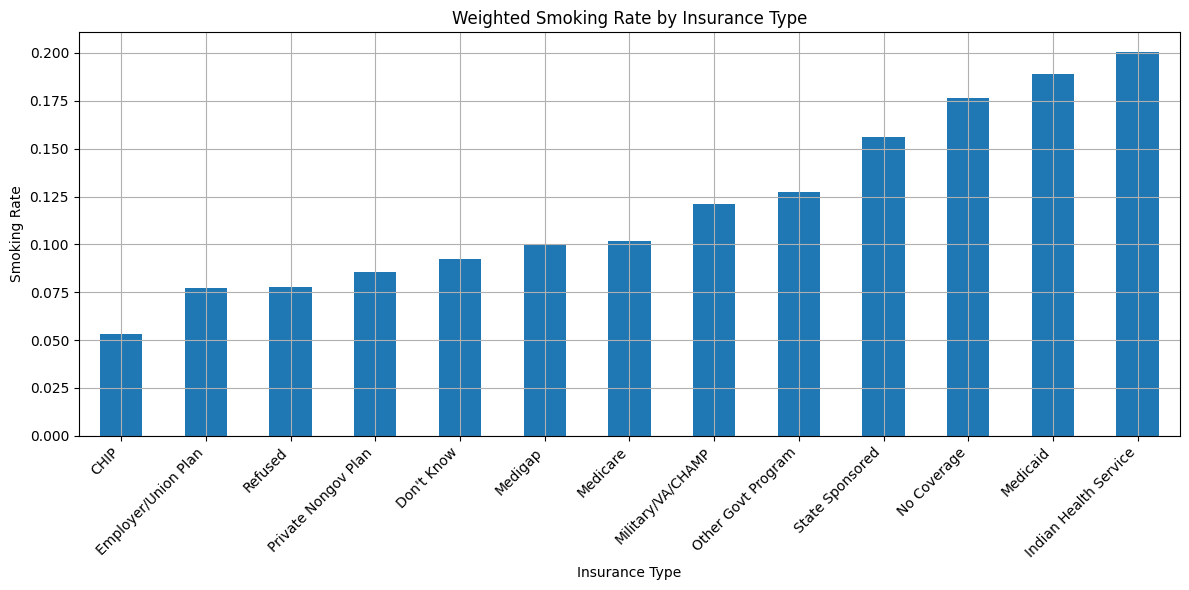

In [152]:
def weighted_smoking_rate(group):
    return np.average(group["is_smoker"], weights=group["WEIGHT"])

smoke_rate_by_ins = (
    df.dropna(subset=["INS_LABEL", "is_smoker", "WEIGHT"])
      .groupby("INS_LABEL")
      .apply(weighted_smoking_rate)
      .sort_values()
)

smoke_rate_by_ins.plot(kind="bar", figsize=(12, 6))
plt.title("Weighted Smoking Rate by Insurance Type")
plt.ylabel("Smoking Rate")
plt.xlabel("Insurance Type")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()



Computes yearly weighted smoking rate for California and for all other states combined; plots both series for comparison.

/tmp/ipykernel_5489/1603419254.py:4: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_5489/1603419254.py:6: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



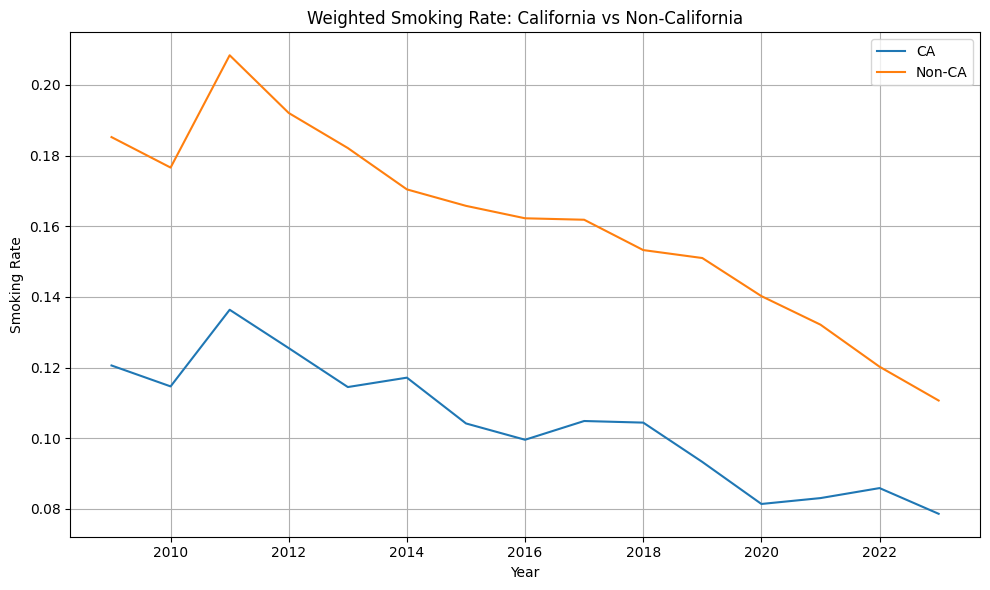

In [153]:
def weighted_smoking_rate(group):
    return np.average(group["is_smoker"], weights=group["WEIGHT"])

ca = df[df["_STATE"] == 6].groupby("YEAR").apply(weighted_smoking_rate)

other = df[df["_STATE"] != 6].groupby("YEAR").apply(weighted_smoking_rate)

pd.DataFrame({"CA": ca, "Non-CA": other}).plot(figsize=(10, 6))
plt.title("Weighted Smoking Rate: California vs Non-California")
plt.ylabel("Smoking Rate")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()



In [154]:
non_expansion_fips = [1, 21, 22, 24, 28, 47, 48, 49, 45, 13]


In [155]:
df["expansion"] = df["_STATE"].apply(lambda x: "Non-Expansion" if x in non_expansion_fips else "Expansion")

In [156]:
def weighted_smoking_rate(group):
    return np.average(group["is_smoker"], weights=group["WEIGHT"])

smoke_rate_by_group = (
    df.dropna(subset=["is_smoker", "WEIGHT", "expansion"])
      .groupby(["YEAR", "expansion"])
      .apply(weighted_smoking_rate)
      .reset_index(name="is_smoker")
)


/tmp/ipykernel_5489/3254237716.py:7: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Creates an interactive line chart (Plotly Express) comparing weighted smoking proportions over time between expansion and non-expansion states; formats axes and layout.

In [157]:
fig = px.line(
    smoke_rate_by_group,
    x="YEAR", y="is_smoker",
    color="expansion",
    markers=True,
    title="Weighted Smoking Rate Over Time: Expansion vs Non-Expansion States (As of 2014)",
    labels={"is_smoker": "Proportion of Current Smokers", "expansion": "Medicaid Expansion Status"}
)
fig.update_layout(yaxis_tickformat=".1%", template="simple_white")
fig.show()



In [ ]:
df_valid = df.dropna(subset=["POORHLTH", "is_smoker", "WEIGHT"])
df_valid = df_valid[~df_valid["POORHLTH"].isin([77, 88, 99])]

df_valid["POORHLTH"] = df_valid["POORHLTH"].astype(int)

df_valid["POORHLTH_LABEL"] = df_valid["POORHLTH"].astype(str)
df_valid["POORHLTH_LABEL"] = pd.Categorical(df_valid["POORHLTH_LABEL"],
                                            categories=[str(i) for i in range(0, 31)],
                                            ordered=True)


Drops rows with missing `POORHLTH`/`is_smoker`/`WEIGHT`, removes invalid codes, casts and factors `POORHLTH` for plotting.

/tmp/ipykernel_5489/4246646518.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_5489/4246646518.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



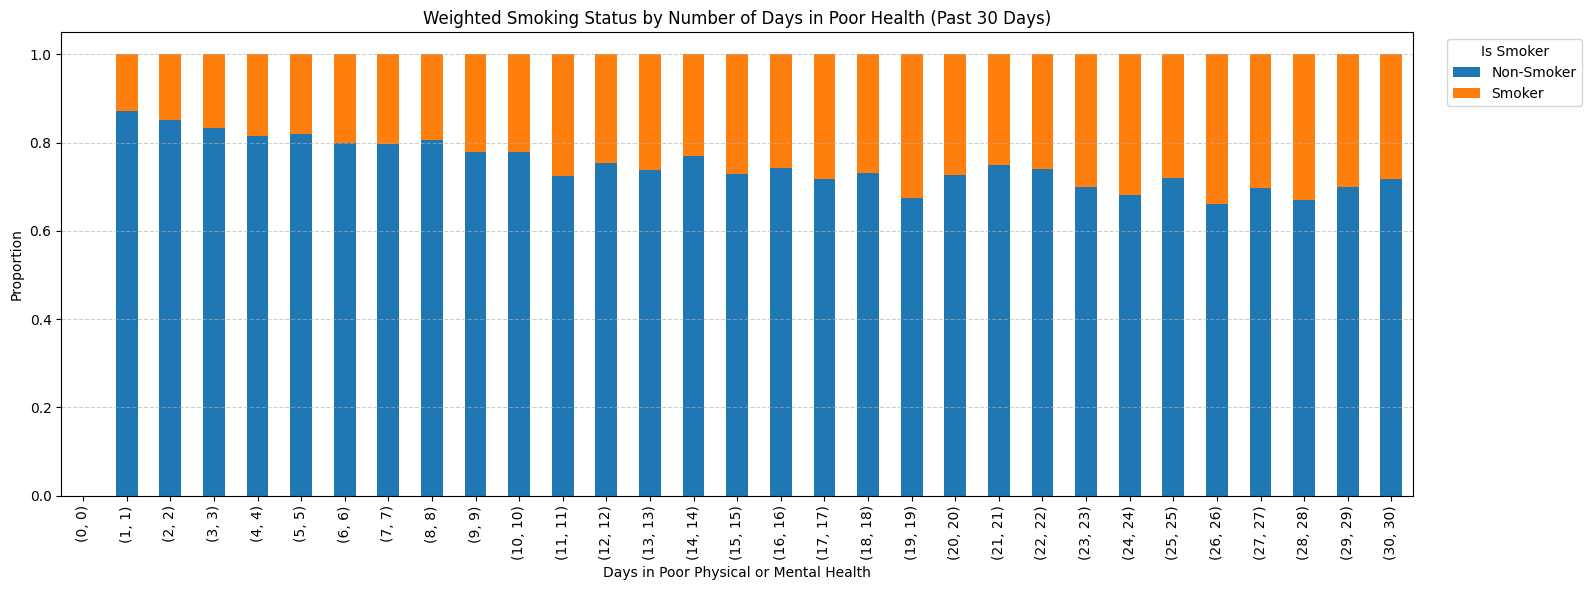

In [159]:
weighted_ct = (
    df_valid.groupby(["POORHLTH_LABEL", "is_smoker"])["WEIGHT"]
    .sum()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
)

# plot
weighted_ct.plot(kind="bar", stacked=True, figsize=(16, 6))
plt.title("Weighted Smoking Status by Number of Days in Poor Health (Past 30 Days)")
plt.xlabel("Days in Poor Physical or Mental Health")
plt.ylabel("Proportion")
plt.xticks(rotation=90)
plt.legend(title="Is Smoker", labels=["Non-Smoker", "Smoker"], bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


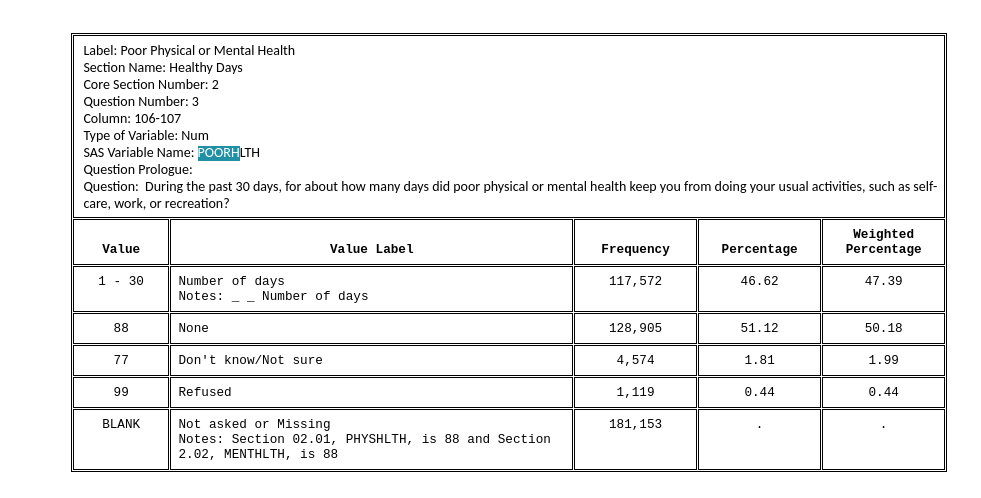

Aggregates weighted counts of current smokers by YEAR × SEXVAR, plots time series lines for male and female estimated smoker counts.

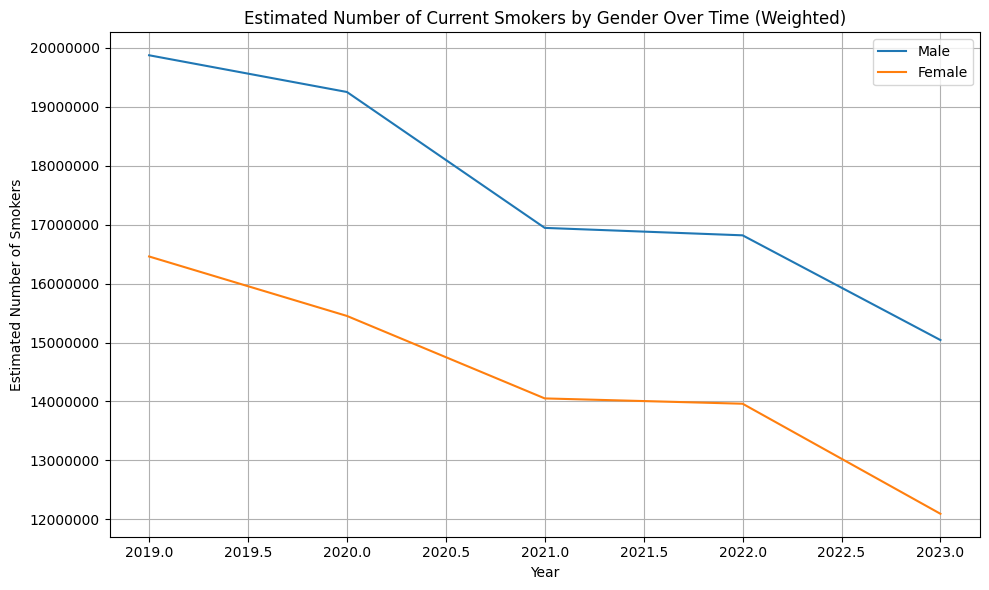

In [160]:

smoking_by_sex = df[df["SMOKDAY2"].isin([1, 2])].copy()


smoking_by_sex_grouped = (
    smoking_by_sex.groupby(["YEAR", "SEXVAR"])["WEIGHT"]
    .sum()
    .unstack()
)

# plot
smoking_by_sex_grouped.plot(figsize=(10, 6))
plt.title("Estimated Number of Current Smokers by Gender Over Time (Weighted)")
plt.xlabel("Year")
plt.ylabel("Estimated Number of Smokers")
plt.legend(["Male", "Female"])
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.tight_layout()
plt.show()


Defines age labels again, computes weighted smoking rate per age group using `WEIGHT`, maps labels, and plots a bar chart of smoking rate by age group.

/tmp/ipykernel_5489/3238732410.py:13: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



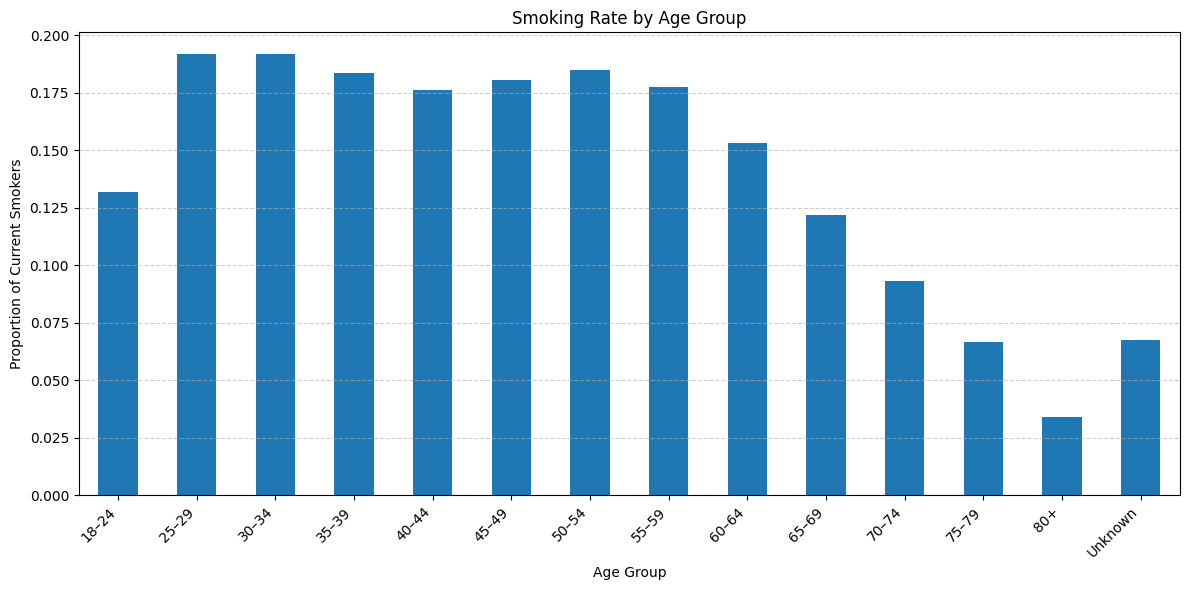

In [161]:
age_labels = {
    1: "18–24", 2: "25–29", 3: "30–34", 4: "35–39",
    5: "40–44", 6: "45–49", 7: "50–54", 8: "55–59",
    9: "60–64", 10: "65–69", 11: "70–74", 12: "75–79",
    13: "80+", 14: "Unknown"
}

def weighted_smoking_rate(group):
    return np.average(group["is_smoker"], weights=group["WEIGHT"])

age_smoking_rate = (
    df.groupby("_AGEG5YR")
      .apply(weighted_smoking_rate)
      .rename(index=lambda x: age_labels.get(x, "Unknown"))
)


# Plot
plt.figure(figsize=(12, 6))
age_smoking_rate.plot(kind="bar")

plt.title("Smoking Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Proportion of Current Smokers")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()